In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from Models.SeEANet import SeEANet
import torch.optim as optim
import torch.nn as nn

In [2]:
def make_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    else:
        pass

In [3]:
class sEMGDataset(Dataset):
    def __init__(self, data_dir):
        self.semgData, self.angleData = [], []
        for file in os.listdir(data_dir):
            dataPath = os.path.join(data_dir, file)
            with open(dataPath, 'rb') as f:
                semg = np.load(f)['semg']
                angle = np.load(f)['angle']
                self.semgData.extend(semg.tolist())
                self.angleData.extend(angle.tolist())
        self.semgData = torch.tensor(self.semgData)
        self.angleData = torch.tensor(self.angleData)

    def __len__(self):
        return len(self.semgData)

    def __getitem__(self, idx):
        # 加载数据
        return self.semgData[idx], self.angleData[idx]

In [4]:
sEMGDataDir = os.path.join(os.getcwd(), "Dataset/NPZFile/S01")

# 实例化数据集
dataset = sEMGDataset(sEMGDataDir)

# 定义划分比例
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
# 数据集分割
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [5]:
# 初始化模型、优化器和损失函数
model = SeEANet()
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
criterion = criterion.cuda()
# print("Model Architecture:")
# print(model)

In [7]:
checkpoint_save_path = os.path.join(os.getcwd(), "Run/test.pth")
checkpoint_save_path = "./Run/test.pth"

best_loss = float('inf')
running_loss_ls = []
test_accuracies = []
for epoch in range(1, 2000+1):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        labels = labels.view(-1,1)
        inputs = inputs.permute(0,2,1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_ls.append(running_loss)

    
    # 测试模型
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.permute(0,2,1)
            labels = labels.view(-1,1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss
    if epoch % 50 == 0:
        print('Epoch %d, Train Loss: %.5f, Test Loss: %.5f'%(epoch, running_loss/256, test_loss/256))

    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(model.state_dict(), checkpoint_save_path)

Epoch 50, Train Loss: 364.50666, Test Loss: 17.58431
Epoch 100, Train Loss: 338.47782, Test Loss: 16.80335
Epoch 150, Train Loss: 307.01633, Test Loss: 15.44668
Epoch 200, Train Loss: 295.21474, Test Loss: 14.08245
Epoch 250, Train Loss: 265.88670, Test Loss: 12.58571
Epoch 300, Train Loss: 232.50989, Test Loss: 11.81447
Epoch 350, Train Loss: 208.92462, Test Loss: 11.06018
Epoch 400, Train Loss: 197.36100, Test Loss: 10.50530
Epoch 450, Train Loss: 182.43558, Test Loss: 9.08570
Epoch 500, Train Loss: 159.98000, Test Loss: 8.36690
Epoch 550, Train Loss: 141.98243, Test Loss: 7.53889
Epoch 600, Train Loss: 127.88595, Test Loss: 6.53995
Epoch 650, Train Loss: 114.82623, Test Loss: 5.86050
Epoch 700, Train Loss: 101.95987, Test Loss: 5.25073
Epoch 750, Train Loss: 87.41148, Test Loss: 4.62760
Epoch 800, Train Loss: 74.94694, Test Loss: 4.03784
Epoch 850, Train Loss: 63.84205, Test Loss: 3.82024
Epoch 900, Train Loss: 55.40027, Test Loss: 2.96053
Epoch 950, Train Loss: 49.27343, Test Loss:

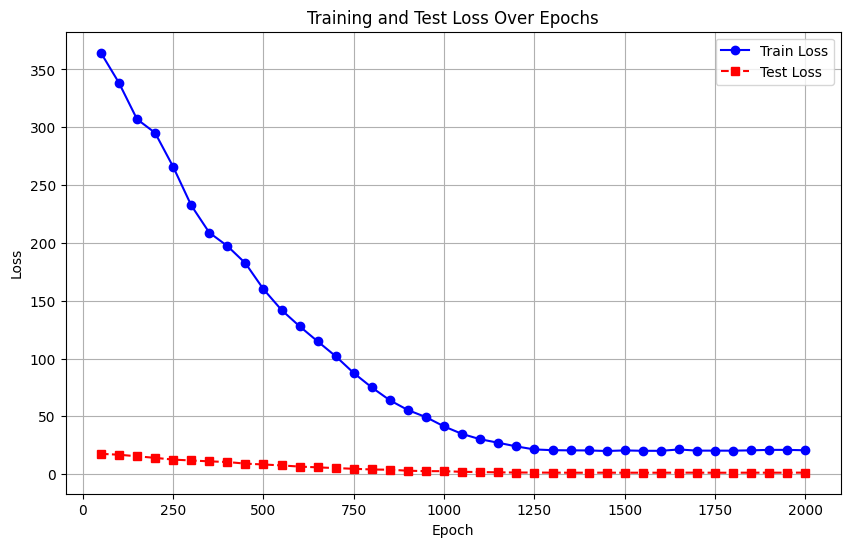

In [8]:
import matplotlib.pyplot as plt

# 数据
epochs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 
          1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]

train_loss = [364.50666, 338.47782, 307.01633, 295.21474, 265.88670, 232.50989, 208.92462, 197.36100, 182.43558, 159.98000, 
              141.98243, 127.88595, 114.82623, 101.95987, 87.41148, 74.94694, 63.84205, 55.40027, 49.27343, 41.25186, 
              34.75465, 30.17220, 27.15161, 23.97645, 21.36197, 20.72873, 20.57132, 20.49456, 20.00959, 20.52212, 
              20.18938, 20.17963, 21.33793, 20.33716, 20.32524, 20.30060, 20.57890, 20.99433, 20.98561, 20.64051]

test_loss = [17.58431, 16.80335, 15.44668, 14.08245, 12.58571, 11.81447, 11.06018, 10.50530, 9.08570, 8.36690, 
             7.53889, 6.53995, 5.86050, 5.25073, 4.62760, 4.03784, 3.82024, 2.96053, 2.59012, 2.56650, 
             2.00896, 1.81318, 1.55451, 1.40970, 1.37725, 1.29305, 1.25367, 1.24425, 1.28507, 1.23786, 
             1.25944, 1.24158, 1.29548, 1.29275, 1.22843, 1.23821, 1.27748, 1.27175, 1.26776, 1.32556]

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='-', color='b')
plt.plot(epochs, test_loss, label='Test Loss', marker='s', linestyle='--', color='r')

# 添加标题和标签
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()